# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

	DateCrawled — дата скачивания анкеты из базы
	VehicleType — тип автомобильного кузова
	RegistrationYear — год регистрации автомобиля
	Gearbox — тип коробки передач
	Power — мощность (л. с.)
	Model — модель автомобиля
	Kilometer — пробег (км)
	RegistrationMonth — месяц регистрации автомобиля
	FuelType — тип топлива
	Brand — марка автомобиля
	Repaired — была машина в ремонте или нет
	DateCreated — дата создания анкеты
	NumberOfPictures — количество фотографий автомобиля
	PostalCode — почтовый индекс владельца анкеты (пользователя)
	LastSeen — дата последней активности пользователя

**Целевой признак**

    Price — цена (евро)


## Подготовка данных

In [2]:
!pip install lightgbm

In [3]:
# Загрузка необходимых библиотек

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn. linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Зададим значения для генерации случайных величин

RANDOM_STATE = 12345

In [5]:
# Загрузим данные из файло
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')


In [6]:
# Выведем первые 5 строк

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
# Выведем общую информацию о дата-фрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
# Для каждого столбца посмотрим кол-во и распределение уникальных значений

for col in df.columns:
    print(col, len(df[col].unique()))
    print(df[col].value_counts())
    print('\n')

DateCrawled 271174
2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-02 14:50:21    5
2016-03-23 13:50:19    5
                      ..
2016-03-20 16:48:06    1
2016-03-22 21:51:04    1
2016-03-11 16:25:36    1
2016-03-31 12:47:30    1
2016-03-19 18:57:12    1
Name: DateCrawled, Length: 271174, dtype: int64


Price 3731
0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64


VehicleType 9
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64


RegistrationYear 151
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: RegistrationYear, Length: 151, dtype: int

In [9]:
# Выведем размер фрейма

df.shape

(354369, 16)

Удалим столбцы, которые, по нашему мнению, неинформативны:
- 'NumberOfPictures' все значения столбыц нулевые;
- 'RegistrationMonth' месяц регистрации вряд ли влияет на цену, там много нулеых значений, заменить их правильно не получится;

In [10]:
# Удалим неинформативные столбцы, проверим размер фрейма

df.drop(['NumberOfPictures', 'RegistrationMonth'], axis=1, inplace=True)
df.shape

(354369, 14)

In [11]:
# Преобразуем столбцы с датами в формат datetime

df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])
df[['DateCreated', 'DateCrawled', 'LastSeen']].dtypes

DateCreated    datetime64[ns]
DateCrawled    datetime64[ns]
LastSeen       datetime64[ns]
dtype: object

In [12]:
# Получим возраст объявления в днях, запишем эту цифру в отдельный столбецб выведем кол-во значений.

df['age_days'] = (df['DateCrawled'] - df['DateCreated']).dt.days
df['age_days'].value_counts(normalize=True)

0      0.966747
1      0.028990
2      0.001532
3      0.000240
4      0.000226
         ...   
239    0.000003
94     0.000003
131    0.000003
78     0.000003
66     0.000003
Name: age_days, Length: 93, dtype: float64

97 % объявлений скачены в день создания.

In [13]:
# Максимальный диапазон скачивания анкет из базы

df['DateCrawled'].max() - df['DateCrawled'].min()

Timedelta('33 days 00:30:36')

Все анкеты были скачены в течении 33 дней.

In [14]:
# Получим актуальность объявления в днях, запишем эту цифру в отдельный столбец.

df['actual_days'] = (df['DateCrawled'] - df['LastSeen']).dt.days
df['actual_days'].value_counts(normalize=True)

 0     0.102800
-2     0.083636
-3     0.081153
-1     0.080679
-4     0.069058
-6     0.059209
-8     0.053896
-5     0.044073
-11    0.036248
-10    0.035610
-7     0.028761
-14    0.027212
-13    0.026489
-9     0.024091
-15    0.022561
-19    0.019762
-12    0.018596
-18    0.017270
-16    0.017104
-17    0.016060
-21    0.015949
-22    0.015498
-23    0.014101
-25    0.011702
-26    0.011192
-27    0.010805
-29    0.009084
-28    0.008914
-30    0.008694
-24    0.008330
-31    0.007851
-20    0.006806
-32    0.003626
-33    0.003127
-34    0.000051
 12    0.000003
Name: actual_days, dtype: float64

Дата последней активности пользователя у 10 % анкет соответсвует дате скачивания, а почти у всех остальных позже чем дата скачивания, это нелогично. Со столбцом 'LastSeen', что-то не так. Удалим его, а также столбцы: 'DateCrowled'(он нам не нужен, так как у нас есть отдельный столбец с 'возрастом' объявления), 'actual_days'.

In [15]:
# Удалим столбцы, проверим размер фрейма

df.drop(['DateCrawled', 'actual_days', 'LastSeen'], axis=1, inplace=True)
df.shape

(354369, 13)

In [16]:
# Преобразуем столбец 'DateCreated' отдельные столбцы с номером года и месяца, а сам исходный
# столбец удалим

df['year_created'] = df['DateCreated'].dt.year
df['month_created'] = df['DateCreated'].dt.month
df.drop('DateCreated', axis=1, inplace=True)

### Обработка пропусков.

In [17]:
# Посчитаем кол-во пропущенных значений в столбцах

df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
PostalCode              0
age_days                0
year_created            0
month_created           0
dtype: int64

Все пропуски в категориальных переменных.

Удалим строки с пропусками в модели авто, без названия модели все остальные данные неиформативны, правильно заполнить модель не получится.

In [18]:
# Удалим строки с пропускаим в столбце 'Model', проверим размер фрейма

df.dropna(subset=['Model'], inplace=True)
df.shape

(334664, 14)

In [19]:
# Заменим пропуски в столбце 'VehicleType' модой этого столбца для соответствующей модели

df.loc[df['VehicleType'].isna(), 'VehicleType'] = df.groupby('Model')['VehicleType'].transform(lambda x: x.fillna((x.mode()[0] if x.count() != 0 else 'unknown')))

In [20]:
df['VehicleType'].isna().sum()

0

In [21]:
# Заменим пропуски в столбце 'Gearbox' на наиболее часто встречающееся значения
 
df['Gearbox'].fillna(df['Gearbox'].mode()[0], inplace=True)

In [22]:
# Заменим пропуски в столбце 'Fueltype' на наиболее часто встречающееся значения
 
df['FuelType'].fillna(df['FuelType'].mode()[0], inplace=True)

In [23]:
# Заменим пропуски в столбце 'Repaired' значением 'no'

df['Repaired'].fillna('no', inplace=True)

In [24]:
# Проверим кол-во оставшихся пропусков

df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
PostalCode          0
age_days            0
year_created        0
month_created       0
dtype: int64

### Обработка аномалий. 

In [25]:
# Посчитаем процент явных дубликатов.

round(df.duplicated().sum()/df.shape[0]*100, 2)

6.74

Явные дубликаты составляют почти 7% данных.

In [26]:
# Удалим явные дубликаты и проверим.

df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Model — модель автомобиля

In [27]:
round((df['Model'] == 'other').sum()/df.shape[0]*100, 2)

7.45

Строки, где в качестве модели указано 'other' составляет чуть более 7 %, их удаление можеи привести к существенной потере данных, придется их оставить.

In [28]:
# Посчитаем кол-во уникальных значений в столбце 'Model'

len(df['Model'].unique())

250

In [29]:
# Выведем отсортированный список уникальных значений модели

sorted(df['Model'].unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

В списке моделей есть неявные дубликаты, например '3er' и '3_reihe', 'range_rover' и 'rangerover'. Приведем их к единому шаблону.

In [30]:
# Создадим шаблон для замен.

repl_list = {'\_reihe': 'er', 'rangerover':'range_rover'}

In [31]:
# Произведем замены по шаблону.

df['Model'].replace(repl_list, regex=True, inplace=True)

VehicleType — тип автомобильного кузова

In [32]:
# Посчитаем кол-во значений с столбце 'VehicleType'

df['VehicleType'].value_counts()

sedan          95568
small          79512
wagon          61636
bus            28959
convertible    18213
coupe          14644
suv            10842
other           2727
Name: VehicleType, dtype: int64

In [33]:
%%time

# Заменим значения 'other' на самый часто встречающийся тип транспортного средства для данной модели


df.loc[df['VehicleType'] == 'other', 'VehicleType'] =\
df.loc[df['VehicleType'] == 'other', 'Model'].\
apply(lambda x: df[df['Model'] == x]['VehicleType'].mode()[0])

Wall time: 1min 1s


In [34]:
# Проверим кол-во оставшихся значений 'other'

df['VehicleType'].value_counts()

sedan          97010
small          79680
wagon          61873
bus            29770
convertible    18229
coupe          14665
suv            10869
other              5
Name: VehicleType, dtype: int64

In [35]:
# Выведем строки с оставшимися значениями 'other'

df[df['VehicleType'] == 'other']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,age_days,year_created,month_created
6425,10000,other,1978,manual,109,serie_2,150000,gasoline,land_rover,no,72070,0,2016,3
6660,15000,other,1982,manual,100,serie_2,70000,gasoline,land_rover,no,72070,0,2016,3
36733,6450,other,1970,manual,57,serie_2,70000,petrol,land_rover,no,65189,0,2016,3
67994,8450,other,2018,manual,46,serie_2,60000,gasoline,land_rover,no,65326,0,2016,3
333564,7000,other,1980,manual,70,serie_2,10000,gasoline,land_rover,no,72070,0,2016,3


Все оставшиеся значения относятся к внедорожникам 'land_rover'.

In [36]:
# Заменим оставшиеся значения 'other' типа транспортного средства для 'land_rover' на 'suv'
# Выведем окончательный список значений столбца

df.loc[df['VehicleType'] == 'other', 'VehicleType'] = 'suv'
df['VehicleType'].value_counts()

sedan          97010
small          79680
wagon          61873
bus            29770
convertible    18229
coupe          14665
suv            10874
Name: VehicleType, dtype: int64

In [37]:
# Проверим наличие неявных дубликатов в столбце 'Brand'

df['Brand'].value_counts().sort_index()

alfa_romeo        2050
audi             26216
bmw              32442
chevrolet         1551
chrysler          1285
citroen           4640
dacia              814
daewoo             471
daihatsu           721
fiat              8568
ford             22558
honda             2521
hyundai           3144
jaguar             467
jeep               625
kia               2192
lada               200
lancia             428
land_rover         501
mazda             4930
mercedes_benz    28874
mini              2917
mitsubishi        2735
nissan            4450
opel             35352
peugeot           9374
porsche            683
renault          16087
rover              380
saab               475
seat              6211
skoda             4963
smart             4715
subaru             691
suzuki            2050
toyota            4211
trabant            474
volkswagen       68268
volvo             2867
Name: Brand, dtype: int64

Неявных дубликатов в столбце 'Brand' больше не обнаружено.

RegistrationYear — год регистрации автомобиля

Год регистрации автомобиля не может быть менее 1768 г.(год выпуска первого авто в мире) и не может быть более 2016 г. (последний год создания нашей анкеты). 

In [38]:
# Посмотрим распределение года регистрации

df['RegistrationYear'].sort_values()

174893    1000
192705    1000
256532    1000
189722    1000
97736     1000
          ... 
301279    9999
217111    9999
331753    9999
28965     9999
62395     9999
Name: RegistrationYear, Length: 312101, dtype: int64

In [39]:
# Посмотрим кол-во уникальных значений в столбце непопадающих под условия

sorted(df.loc[(df['RegistrationYear'] > 2016) | (df['RegistrationYear'] < 1768), 'RegistrationYear'].\
unique())

[1000,
 1001,
 1111,
 1200,
 1234,
 1300,
 1400,
 1500,
 1600,
 1602,
 2017,
 2018,
 2019,
 2066,
 2200,
 2290,
 2500,
 2900,
 3000,
 3700,
 4000,
 4500,
 5000,
 5555,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,
 8500,
 9000,
 9999]

In [40]:
# Заменим значения года более 2016 и менее 1768 на Nan

df.loc[(df['RegistrationYear'] > 2016) | (df['RegistrationYear'] < 1768), 'RegistrationYear'] = None

In [41]:
# Поссчитаем кол-во получившихся замен

df['RegistrationYear'].isna().sum()

11917

In [42]:
# Заменим пропуски на самые частые значения для соответствующей модели

df.loc[df['RegistrationYear'].isna(), 'RegistrationYear'] = \
        df.groupby('Model')['RegistrationYear'].transform(lambda x: x.fillna(x.mode()[0]))

In [43]:
# Проверим остались ли пропуски

df['RegistrationYear'].isna().sum()

0

In [44]:
# Посмотрим оставшиеся года регистрации после замен

sorted(df['RegistrationYear'].unique())

[1800.0,
 1910.0,
 1919.0,
 1923.0,
 1927.0,
 1928.0,
 1929.0,
 1930.0,
 1931.0,
 1932.0,
 1933.0,
 1934.0,
 1935.0,
 1936.0,
 1937.0,
 1938.0,
 1941.0,
 1942.0,
 1943.0,
 1945.0,
 1947.0,
 1949.0,
 1950.0,
 1951.0,
 1952.0,
 1953.0,
 1954.0,
 1955.0,
 1956.0,
 1957.0,
 1958.0,
 1959.0,
 1960.0,
 1961.0,
 1962.0,
 1963.0,
 1964.0,
 1965.0,
 1966.0,
 1967.0,
 1968.0,
 1969.0,
 1970.0,
 1971.0,
 1972.0,
 1973.0,
 1974.0,
 1975.0,
 1976.0,
 1977.0,
 1978.0,
 1979.0,
 1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0]

In [45]:
df[df['RegistrationYear'] < 1952]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,age_days,year_created,month_created
15,450,small,1910.0,manual,0,ka,5000,petrol,ford,no,24148,0,2016,3
1928,7000,suv,1945.0,manual,48,other,150000,petrol,volkswagen,no,58135,0,2016,3
10183,1250,sedan,1910.0,manual,0,other,5000,petrol,audi,no,18445,0,2016,3
23750,3900,wagon,1910.0,manual,90,passat,150000,petrol,volkswagen,no,88662,0,2016,3
27525,13300,sedan,1949.0,manual,99,other,60000,petrol,chrysler,no,28279,0,2016,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344459,18500,coupe,1950.0,manual,0,other,150000,petrol,chevrolet,no,61276,0,2016,4
346046,18900,suv,1943.0,manual,60,other,150000,petrol,volkswagen,no,51065,0,2016,3
348932,11000,suv,1950.0,manual,0,other,5000,petrol,chevrolet,no,79098,0,2016,4
351682,11500,sedan,1800.0,manual,16,other,5000,petrol,fiat,no,16515,1,2016,3


Проверка показала, что все года до 1952 указаны неверно и соответствуют более современным авто, за исключением 'Opel Kadett'

In [46]:
%%time

# Заменим год создания менее 1952 г. на самый часто встречающийся год для соответствующей модели

df.loc[(df['RegistrationYear'] < 1952) & (df['Model'] != 'kadett'), 'RegistrationYear'] =\
df[(df['RegistrationYear'] < 1952) & (df['Model'] != 'kadett')]['Model'].\
apply(lambda x: df[df['Model'] == x]['RegistrationYear'].mode()[0])

Wall time: 2.5 s


In [47]:
# Посмотрим оставшиеся года регистрации после замен

sorted(df['RegistrationYear'].unique())

[1938.0,
 1952.0,
 1953.0,
 1954.0,
 1955.0,
 1956.0,
 1957.0,
 1958.0,
 1959.0,
 1960.0,
 1961.0,
 1962.0,
 1963.0,
 1964.0,
 1965.0,
 1966.0,
 1967.0,
 1968.0,
 1969.0,
 1970.0,
 1971.0,
 1972.0,
 1973.0,
 1974.0,
 1975.0,
 1976.0,
 1977.0,
 1978.0,
 1979.0,
 1980.0,
 1981.0,
 1982.0,
 1983.0,
 1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1996.0,
 1997.0,
 1998.0,
 1999.0,
 2000.0,
 2001.0,
 2002.0,
 2003.0,
 2004.0,
 2005.0,
 2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0]

Power — мощность (л. с.)

In [48]:
# Посмотрим на уникальные значений в столбце 'Power'

sorted(df['Power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


Мощность не может быть меньше 0, также авторы объявлений часто указывают объем двигателя вместо мощности в л.с.
Проведем соответствующие замены.

In [49]:
# Посмотрим на строки неудовлетворяющие нашим условиям

df.loc[(df['Power'] > 500) | (df['Power'] <= 0)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,age_days,year_created,month_created
0,480,sedan,1993.0,manual,0,golf,150000,petrol,volkswagen,no,70435,0,2016,3
15,450,small,2000.0,manual,0,ka,5000,petrol,ford,no,24148,0,2016,3
32,245,sedan,1994.0,manual,0,golf,150000,petrol,volkswagen,no,44145,0,2016,3
37,1500,bus,2016.0,manual,0,kangoo,150000,gasoline,renault,no,46483,0,2016,3
40,0,small,1990.0,manual,0,corsa,150000,petrol,opel,no,56412,0,2016,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354318,400,wagon,1991.0,manual,0,legacy,150000,petrol,subaru,no,24558,0,2016,3
354332,7900,bus,2007.0,manual,0,b_klasse,125000,petrol,mercedes_benz,no,30519,0,2016,3
354335,390,small,1997.0,auto,0,corsa,100000,petrol,opel,yes,17509,0,2016,4
354346,2600,sedan,2005.0,auto,0,c_klasse,150000,petrol,mercedes_benz,no,61169,0,2016,3


In [50]:
# Заменим все значения в столбце 'Power' более 500 и менее или равно 0 на NaN

df.loc[(df['Power'] > 500) | (df['Power'] <= 0), 'Power'] = None

In [51]:
# Посчитаем кол-во получившихся пропущенных значений

df['Power'].isna().sum()

32671

In [52]:
# Все пропущенные значения заменим на наиболее часто встречающееся для данной модели,
# если таковые отсутствуют то на -1

df['Power'] =\
df.groupby('Model')['Power'].transform(lambda x: x.fillna((x.mode()[0] if x.count() != 0 else -1)))

In [53]:
df[df['Brand'] == 'land_rover'].groupby('Model')['Power'].median()

Model
defender              122.0
discovery             190.0
freelander            117.0
other                  69.0
range_rover           182.0
range_rover_evoque    296.0
range_rover_sport     190.0
serie_1                -1.0
serie_2                63.0
serie_3                69.0
Name: Power, dtype: float64

In [54]:
# Посмотрим отсашиеся незаполненными корректно строки.

df[df['Power'] <=0]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode,age_days,year_created,month_created
234296,3800,wagon,1978.0,manual,-1.0,serie_1,30000,gasoline,land_rover,no,49824,0,2016,3
280216,0,wagon,1970.0,manual,-1.0,serie_1,100000,petrol,land_rover,no,88634,0,2016,4


In [55]:
# У модели 'series_1' бренда 'land_rover' мощность равна 52 л.с 

df.loc[df['Power'] <=0, 'Power'] = 52

FuelType — тип топлива

In [56]:
# Посчитаем кол-во значений в столбце

df['FuelType'].value_counts()

petrol      217777
gasoline     88793
lpg           4615
cng            516
hybrid         203
other          132
electric        65
Name: FuelType, dtype: int64

In [57]:
# Заменим в столбце 'FuelType' все значения gasoline на petrol, это одно и тоже

df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'disel'

Price — цена (евро)

In [58]:
# Посчитаем процент нулевых значений в столбце цена. 

round((df['Price'] == 0).sum()/df.shape[0]*100,2 )

2.52

Кол-во нулевых значений в столбце 'price' составляет чуть более 2,5 %.

In [59]:
# Удалим строки, значения столбца 'Price' в которых равно 0, они непригодны для обучения модели

df.drop(df[df['Price'] == 0].index, axis=0, inplace=True)
(df['Price'] == 0).sum()

0

PostalCode — почтовый индекс владельца анкеты (пользователя)

In [60]:
# Посчитаем кол-во значений признака

len(df['PostalCode'].unique())

8124

Почтовый индекс соответствует региону, скорее это можно было бы использовать как категориальный признак, однако кол-во значений более 8000 не позволит это сделать - не хватит ресурсов.

In [61]:
# Удалим столбец из дата-фрейма

df.drop(['PostalCode'], axis=1, inplace=True)

In [62]:
# Преобразуем типы данных из float в int

df['RegistrationYear'] = df['RegistrationYear'].astype('int64')
df['Power'] = df['Power'].astype('int64')
df['year_created'] = df['year_created'].astype('int64')
df['month_created'] = df['month_created'].astype('int64')

In [63]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired', 'age_days',
       'year_created', 'month_created'],
      dtype='object')

In [64]:
df.dtypes

Price                int64
VehicleType         object
RegistrationYear     int64
Gearbox             object
Power                int64
Model               object
Kilometer            int64
FuelType            object
Brand               object
Repaired            object
age_days             int64
year_created         int64
month_created        int64
dtype: object

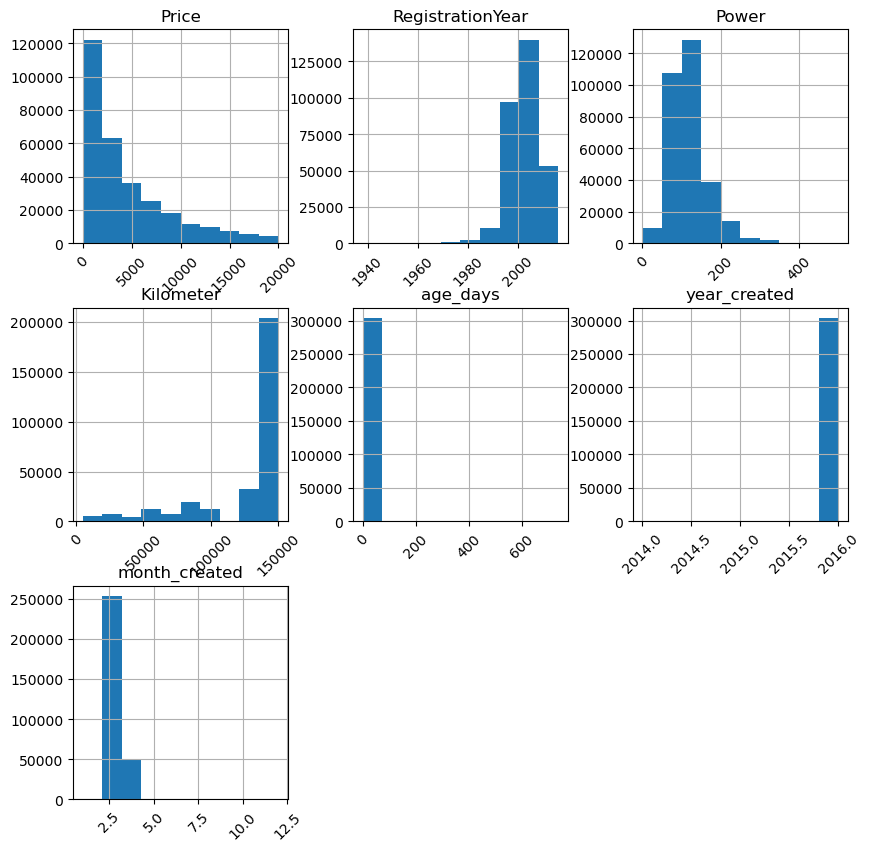

In [65]:
# Посмотрим распределение данных по столбцам

df.hist(figsize=(10,10), xrot=45);

<AxesSubplot:>

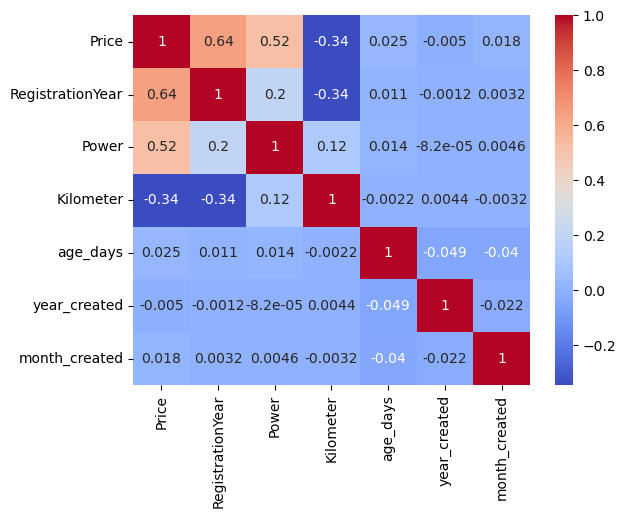

In [66]:
# # Построим матрицу корреляции с испрользованием тепловой карты

sns.heatmap(df.corr(method="spearman"),  cmap='coolwarm', annot=True)

Есть корреляция между мощностью и ценой и годом и ценой.

***Выводы по разделу:***

-  Удалим столбцы, которые, по нашему мнению, неинформативны:
   - 'NumberOfPictures' все значения столбыц нулевые;
   - 'RegistrationMonth' месяц регистрации вряд ли влияет на цену, там много нулеых значений, заменить их правильно не получится;
   - 'PostalCode' почтовый индекс соответствует региону, скорее всего это можно было бы использовать как категориальный признак, однако кол-во значений более 8000 не позволит это сделать - не хватит ресурсов;
- Дата последней активности пользователя у 10 % анкет соответсвует дате скачивания, а почти у всех остальных позже чем дата скачивания, это нелогично. Со столбцом 'LastSeen', что-то не так. Удалим его, а также столбцы: 'DateCrowled'(он нам не нужен, так как мы сгенерировали отдельный столбец с 'возрастом' объявления 'actual_days';
- Столбец 'DateCreated' разделили на два отдельных для года и месяца;

Обработка пропусков:
- Удалили строки с пропусками в модели авто, без названия модели все остальные данные неиформативны, правильно заполнить модель не получится;
- Заменили пропуски в столбце 'VehicleType' модой этого значения для соответствующей модели;
- Заменили пропуски в столбце 'Gearbox' на наиболее часто встречающееся значения;
- Заменили пропуски в столбце 'Fueltype' на наиболее част встречающееся значения;
- Заменили пропуски в столбце 'Repaired' значением 'no';

Обрабокта аномалий:
- Удалили явные дубликаты;
- В списке моделей есть неявные дубликаты, например '3er' и '3_reihe', 'range_rover' и 'rangerover'. Привели их к единому шаблону;
-  В столбце 'VehicleType' заменили значения 'other' на самый часто встречающийся тип транспортного средства для каждой модели;
- Заменим значения года более 2016 г. и менее 1952 г. на самые частые значения для соответствующей марки;
- Заменим все значения в столбце 'Power' более 500 и менее или равные 0 на наиболее часто встречающееся для каждой модели;
- Заменили в столбце 'FuelType' все значения gasoline на petrol, это одно и тоже;
- Удалим строки, значения столбца 'Price' в которых равно 0, они непригодны для обучения модели

## Обучение моделей

### Подготовка признаков.

In [67]:
# Выведем общую информацию о дата-фрейме.

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304222 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             304222 non-null  int64 
 1   VehicleType       304222 non-null  object
 2   RegistrationYear  304222 non-null  int64 
 3   Gearbox           304222 non-null  object
 4   Power             304222 non-null  int64 
 5   Model             304222 non-null  object
 6   Kilometer         304222 non-null  int64 
 7   FuelType          304222 non-null  object
 8   Brand             304222 non-null  object
 9   Repaired          304222 non-null  object
 10  age_days          304222 non-null  int64 
 11  year_created      304222 non-null  int64 
 12  month_created     304222 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 32.5+ MB


In [68]:
# Проверим размер дата-фрейма после предобработки

df.shape

(304222, 13)

In [69]:
# Создадим списки численных и категориальных признаков.

num_features = ['RegistrationYear', 'Power', 'Kilometer', 'age_days']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'year_created',\
               'month_created']

In [70]:
# Выделяем признаки и проверяем размер.

features = df.drop(['Price'], axis=1)
print(features.shape)

(304222, 12)


In [71]:
# Выделяем целевой признак и проверяем размер.

target = df['Price']
print(target.shape)

(304222,)


In [72]:
# Разделяем выборки на обучающую и тестовую в соотношении 70:30. проверяем размерности

features_train, features_test, target_train, target_test =\
train_test_split(features, target, test_size=0.3, random_state=RANDOM_STATE)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(212955, 12)
(212955,)
(91267, 12)
(91267,)


In [73]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,age_days,year_created,month_created
237642,small,1999,manual,60,polo,150000,petrol,volkswagen,no,0,2016,3
165187,sedan,2002,manual,122,carisma,80000,petrol,mitsubishi,no,0,2016,3
292139,small,2016,auto,71,fortwo,100000,petrol,smart,no,0,2016,4
215178,sedan,2003,manual,131,passat,150000,petrol,volkswagen,no,0,2016,3
179144,sedan,2009,auto,170,golf,150000,disel,volkswagen,no,0,2016,3


In [74]:
# Преобразуем признаки: масштабируем количественные и закодируем категориальные

transformer = ColumnTransformer(transformers =[
    ('ohe', OneHotEncoder(sparse = False, drop='first', handle_unknown='ignore'), cat_features),
    ('scal', StandardScaler(), num_features),
      
], remainder ='passthrough')

### Модель линейной регрессии.

In [75]:
# Pipeline для масштабирования признаков и обучения модели для линейной регрессии

pipe_reg = Pipeline(steps=[
    ('trans',transformer),
    ('reg', LinearRegression())
], verbose=False)

In [76]:
%%time

# Кросс-валидация для модели линейной регрессии.

scores = -cross_val_score(pipe_reg, features_train, target_train, cv=5, scoring=\
                          'neg_root_mean_squared_error')

Wall time: 28.3 s


Время обучения и кросс-валидации 1 мин. 45 сек.

In [77]:
# Посчитаем и выведем среднее значения при кросс-валидации для линйеной регрессии.

rmse_reg = round(scores.mean(), 3)
print(rmse_reg)

2683.03


In [78]:
# Обучим модель линейной регрессии на обучающей выборке и запомним время.

reg_fit_time = %timeit -n1 -r1 -o pipe_reg.fit(features_train, target_train)

6.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [79]:
# Переведем в float

reg_fit_time = reg_fit_time.average

In [80]:
# Получим предсказания на тествой выборке и запомним время.

reg_pred_time = %timeit -n1 -r1 -o  predictions = pipe_reg.predict(features_train)

950 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [81]:
# Переведем в float

reg_pred_time = reg_pred_time.average

In [82]:
reg_fit_time = round(reg_fit_time, 2)
reg_pred_time = round(reg_pred_time, 2)
print('Среднее время обучения линейной регрессии сек.:', reg_fit_time)
print('Среднее вреия предсказаний линйеной регресии сек.:', reg_pred_time)
print('RMSE для линейной модели при кросс-валидации:', rmse_reg)

Среднее время обучения линейной регрессии сек.: 6.79
Среднее вреия предсказаний линйеной регресии сек.: 0.95
RMSE для линейной модели при кросс-валидации: 2683.03


Лучшее значение RMSE на модели линейной регрессии на кросс-валидации 2683.

### Модель решающего дерева

In [83]:
# Преобразуем признаки: масштабируем количественные и закодируем категориальные при помощи
# OrdinalEncoder

transformer_tree = ColumnTransformer(transformers =[
    ('ohe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-2),\
     cat_features),
    ('scal', StandardScaler(), num_features),
      
], remainder ='passthrough')

In [84]:
# Создадим Pipeline для масштабирования признаков,обучения модели решающего дерева
# и подобора параметров

pipe_tree = Pipeline(steps=[
    ('trans_tr',transformer_tree),
    ('tree', DecisionTreeRegressor(random_state=RANDOM_STATE))
], verbose=False)

In [85]:
# Параметры для GridseachCV

grid_space_tree={'tree__max_depth': [2,5,10,20],
            'tree__max_features':[1,3,5,10],
            'tree__min_samples_leaf':[1,2,3],
            'tree__min_samples_split':[2,3]
           }

In [86]:
# Создадим подборщик параметров для модели дерева решений

tree_grid = GridSearchCV(pipe_tree,param_grid=grid_space_tree,n_jobs=-1,scoring= \
                         'neg_root_mean_squared_error')

In [87]:
%%time

# Обучение модели дерева, подбор параметров и подсчет метрики 

tree_model = tree_grid.fit(features_train, target_train)

rmse_tree = -tree_model.best_score_
params_tree = tree_model.best_params_

Wall time: 2min 55s


Время обучения и подбор параметров составило 4 мин.

In [88]:
# Выведем значения метрики на кросс-валидации и лучшие из подобранных параметров

rmse_tree = round(rmse_tree, 3)
print(rmse_tree)
params_tree

1941.801


{'tree__max_depth': 20,
 'tree__max_features': 10,
 'tree__min_samples_leaf': 3,
 'tree__min_samples_split': 2}

In [89]:
# Создадим Pipeline для масштабирования признаков и обучения модели решающего дерева
# с лучшим из подобранных параметров

pipe_tree_1 = Pipeline(steps=[
    ('trans_tr',transformer_tree),
    ('tree', DecisionTreeRegressor(max_depth=20,
                                   max_features=10,
                                   min_samples_leaf=3,
                                   min_samples_split=2,
                                   random_state=RANDOM_STATE))
], verbose=False)

In [90]:
# Обучим модель дерева решений на обучающей выборке и запомним время.

tree_fit_time = %timeit -n1 -r1 -o pipe_tree_1.fit(features_train, target_train)

1.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [91]:
# Переведем в float

tree_fit_time = tree_fit_time.average

In [92]:
# Получим предсказания на обучающей выборке и запомним время.

tree_pred_time = %timeit -n1 -r1 -o tree_predictions = pipe_tree_1.predict(features_train)

367 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [93]:
# Переведем в float

tree_pred_time = tree_pred_time.average

In [94]:
tree_fit_time = round(tree_fit_time, 2)
tree_pred_time = round(tree_pred_time, 2)
print('Среднее время обучения решающего дерева сек.:', tree_fit_time)
print('Среднее вреия предсказаний решающего дерева сек.:', tree_pred_time)
print('Лучшее значение RMSE на модели решающего дерева на кросс-валидации:', rmse_tree)

Среднее время обучения решающего дерева сек.: 1.29
Среднее вреия предсказаний решающего дерева сек.: 0.37
Лучшее значение RMSE на модели решающего дерева на кросс-валидации: 1941.801


### Модель Ridge.

In [95]:
# Pipeline для масштабирования признаков, обучения модели Ridge и подбора параметров

pipe_ridge = Pipeline(steps=[
    ('trans',transformer),
    ('ridge', Ridge(random_state=RANDOM_STATE))
], verbose=False)

In [96]:
# Параметры для RandomseachCV

ridge_space ={'ridge__alpha': np.arange(0.0,10.0,0.1)}

In [97]:
# Создадим подборщик параметров для модели Ridge

ridge_random = RandomizedSearchCV(pipe_ridge,param_distributions=ridge_space,\
                                        n_jobs=-1, n_iter=3, scoring='neg_root_mean_squared_error')

In [98]:
%%time

# Обучение модели Ridge, подбор параметров и подсчет метрики 

ridge_model = ridge_random.fit(features_train, target_train)

rmse_ridge = -ridge_model.best_score_
params_ridge = ridge_model.best_params_

Wall time: 22 s


Время обучения и подбора параметров около 1 мин.

In [99]:
# Выведем лучшее значение для Ridge на кросс-валидации и лучший из подобранных параметров

rmse_ridge = round(rmse_ridge, 3)
print(rmse_ridge)
params_ridge

2683.065


{'ridge__alpha': 5.0}

In [100]:
# Создадим Pipeline для масштабирования признаков и обучения модели Ridge с лучшим из подобранных
# параметров

pipe_ridge_1 = Pipeline(steps=[
    ('trans',transformer),
    ('ridge', Ridge(alpha=5.1, random_state=RANDOM_STATE))
], verbose=False)

In [101]:
# Обучим модель на обучающей выборке и запомним время.

ridge_fit_time = %timeit -n1 -r1 -o pipe_ridge_1.fit(features_train, target_train)

1.99 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [102]:
# Переведем в float

ridge_fit_time = ridge_fit_time.average

In [103]:
# Сделаем предсказания на тестовой выборке и запомним время.

ridge_pred_time = %timeit -n1 -r1 -o ridge_predictions = pipe_ridge_1.predict(features_train)

937 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [104]:
# Переведем в float

ridge_pred_time = ridge_pred_time.average

In [105]:
ridge_fit_time = round(ridge_fit_time, 2)
ridge_pred_time = round(ridge_pred_time, 2)
print('Среднее время обучения решающего дерева сек.:', ridge_fit_time)
print('Среднее вреия предсказаний решающего дерева сек.:', ridge_pred_time)
print('Лучшее значение RMSE для модели Ridge на кросс-валидации:', rmse_ridge)

Среднее время обучения решающего дерева сек.: 1.99
Среднее вреия предсказаний решающего дерева сек.: 0.94
Лучшее значение RMSE для модели Ridge на кросс-валидации: 2683.065


### Модель LightGBM.

In [106]:
# Pipeline для масштабирования признаков, обучения модели LGBMregressor и подбора параметров

pipe_lgbm = Pipeline(steps=[
    ('trans_tree',transformer_tree),
    ('lgbm', LGBMRegressor(objective='regression', random_state=RANDOM_STATE))
], verbose=False)

In [107]:
# Параметры для RandomseachCV для модели LGBMRegressor

param_lgbm = {'lgbm__learning_rate': [0.1, 0.5],
              'lgbm__num_iterations' : [50, 100]        
    }

In [108]:
# Создадим подборщик параметров для модели LGBMRegressor

light_lgbm = RandomizedSearchCV(pipe_lgbm,param_distributions=param_lgbm,\
                                        n_jobs=-1, n_iter=4,cv=2, scoring='neg_root_mean_squared_error')

In [109]:
%%time

# Обучение модели LGBM, подбор параметров и подсчет метрики 

lgbm_model = light_lgbm.fit(features_train, target_train)

rmse_lgbm = -lgbm_model.best_score_
params_lgbm= lgbm_model.best_params_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 212955, number of used features: 11
[LightGBM] [Info] Start training from score 4608.020770
Wall time: 12.3 s


Время обучения и подбора параметров LGBMRegressor почти 13 сек.

In [110]:
# Выведем лучше результаты кросс-валидации и лучшие параметры.

rmse_lgbm = round(rmse_lgbm, 3)
print(rmse_lgbm)
params_lgbm

1753.132


{'lgbm__num_iterations': 100, 'lgbm__learning_rate': 0.5}

In [111]:
# Pipeline для масштабирования признаков и обучения модели LGBMregressor с найденными параметрами

pipe_lgbm_1 = Pipeline(steps=[
    ('trans',transformer),
    ('lgbm', LGBMRegressor(objective='regression', random_state=RANDOM_STATE,\
                          learning_rate=0.5, num_iteration=100))
], verbose=False)

In [112]:
# Обучим модель на обучающей выборке и запомним время.

lgbm_fit_time = %timeit -n1 -r1 -o pipe_lgbm_1.fit(features_train, target_train)

[LightGBM] [Warning] num_iterations is set=100, num_iteration=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 212955, number of used features: 285
[LightGBM] [Info] Start training from score 4608.020770
2.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [113]:
# Переведем во float

lgbm_fit_time = lgbm_fit_time.average

In [114]:
# Сделаем предсказания на обучающей выборке и запомним время.

lgbm_pred_time = %timeit -n1 -r1 -o pipe_lgbm_1.predict(features_train)

1.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [115]:
# Переведем во float

lgbm_pred_time = lgbm_pred_time.average

In [116]:
lgbm_fit_time = round(lgbm_fit_time, 2)
lgbm_pred_time = round(lgbm_pred_time, 2)
print('Среднее время обучения LgbmRegressor сек.:', lgbm_fit_time)
print('Среднее время предсказаний LgbmRegressor сек.:', lgbm_pred_time)
print('Лучшее значение RMSE для модели LightGBM на кросс-валидаци:', rmse_lgbm)

Среднее время обучения LgbmRegressor сек.: 2.61
Среднее время предсказаний LgbmRegressor сек.: 1.63
Лучшее значение RMSE для модели LightGBM на кросс-валидаци: 1753.132


### Модель Catboost.

In [117]:
# Преобразуем признаки: масштабируем количественные, категориальные оставим как есть

transformer_cat = ColumnTransformer(transformers =[
    ('scal', StandardScaler(), num_features),
], remainder ='passthrough')

In [118]:
# Pipeline для масштабирования признаков, обучения модели и подбора параметров CatBoostRegressor 

pipe_cat = Pipeline(steps=[
          ('trans_1', transformer_cat),
          ('cat', CatBoostRegressor(random_state=RANDOM_STATE,\
                            cat_features=[4, 5, 6, 7, 8, 9, 10, 11], verbose=10))
], verbose=False)

In [119]:
# Параметры для RandomseachCV для модели CatBoostRegressor

param_cat = {
            'cat__learning_rate': [0.1, 0.5],
            'cat__iterations' : [50, 100]
            }

In [120]:
# Создадим подборщик параметров для модели LGBMRegressor

cat = RandomizedSearchCV(pipe_cat,param_distributions=param_cat,\
                                        n_jobs=-1, n_iter=4,cv=2, scoring='neg_root_mean_squared_error')

In [121]:
%%time

# Обучение модели CatBoostRegressor, подбор параметров и подсчет метрики 

cat_model = cat.fit(features_train, target_train)

rmse_cat_model = -cat_model.best_score_
params_cat_model = cat_model.best_params_

0:	learn: 3236.7013225	total: 341ms	remaining: 33.7s
10:	learn: 1959.6218654	total: 1.42s	remaining: 11.5s
20:	learn: 1861.6455215	total: 2.4s	remaining: 9.02s
30:	learn: 1818.5833069	total: 3.25s	remaining: 7.22s
40:	learn: 1791.7320319	total: 4.12s	remaining: 5.93s
50:	learn: 1771.5032936	total: 4.99s	remaining: 4.79s
60:	learn: 1754.1615150	total: 5.86s	remaining: 3.74s
70:	learn: 1741.9917804	total: 6.7s	remaining: 2.73s
80:	learn: 1729.8437278	total: 7.55s	remaining: 1.77s
90:	learn: 1717.8190131	total: 8.4s	remaining: 831ms
99:	learn: 1708.8307235	total: 9.18s	remaining: 0us
Wall time: 57.7 s


Время обучения и подбора параметров 60 сек.

In [122]:
rmse_cat_model = round(rmse_cat_model, 3)
print(rmse_cat_model)
params_cat_model

1776.746


{'cat__learning_rate': 0.5, 'cat__iterations': 100}

In [123]:
# Pipeline для масштабирования признаков, обучения модели на подобранных параметрах CatBoostRegressor 

pipe_cat_1 = Pipeline(steps=[
          ('trans_1', transformer_cat),
          ('cat', CatBoostRegressor(learning_rate=0.5, random_state=RANDOM_STATE,\
                            iterations=100, cat_features=[4, 5, 6, 7, 8, 9, 10, 11], verbose=10))
], verbose=False)

In [124]:
# Обучим модель на обучающей выборке и запомним время.

cat_fit_time = %timeit -n1 -r1 -o pipe_cat_1.fit(features_train, target_train)

0:	learn: 3236.7013225	total: 119ms	remaining: 11.8s
10:	learn: 1959.6218654	total: 1.12s	remaining: 9.08s
20:	learn: 1861.6455215	total: 2.27s	remaining: 8.55s
30:	learn: 1818.5833069	total: 3.27s	remaining: 7.28s
40:	learn: 1791.7320319	total: 4.22s	remaining: 6.07s
50:	learn: 1771.5032936	total: 5.16s	remaining: 4.96s
60:	learn: 1754.1615150	total: 6.21s	remaining: 3.97s
70:	learn: 1741.9917804	total: 7.14s	remaining: 2.92s
80:	learn: 1729.8437278	total: 8.08s	remaining: 1.89s
90:	learn: 1717.8190131	total: 8.99s	remaining: 889ms
99:	learn: 1708.8307235	total: 9.83s	remaining: 0us
12.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [125]:
# Переведем во float

cat_fit_time = cat_fit_time.average

In [126]:
# Получим предсказания на обучающей выборке и запомним время.

cat_pred_time  = %timeit -n1 -r1 -o pipe_cat_1.predict(features_train)

1.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [127]:
# Переведем во float

cat_pred_time = cat_pred_time.average

In [128]:
cat_fit_time = round(cat_fit_time, 2)
cat_pred_time = round(cat_pred_time, 2)
print('Среднее время обучения CatBoostRegressor сек.:', cat_fit_time)
print('Среднее вреvя предсказаний CatBoostRegressor  сек.:', cat_pred_time)
print('Лучшее значение RMSE для модели CatBoostRegressor на кросс-валидации:', rmse_cat_model)

Среднее время обучения CatBoostRegressor сек.: 12.13
Среднее вреvя предсказаний CatBoostRegressor  сек.: 1.08
Лучшее значение RMSE для модели CatBoostRegressor на кросс-валидации: 1776.746


## Анализ моделей

In [129]:
# Cоставим списки по результатам обучения и проверки моделей.

models = ['Линейная регрессия', 'Решающее дерево', 'Ridge', 'LGBMRegressor', 'CatBoostRegressor']
res = [[rmse_reg, reg_fit_time, reg_pred_time],
        [rmse_tree, tree_fit_time, tree_pred_time],
        [rmse_ridge, ridge_fit_time, ridge_pred_time],
        [rmse_lgbm, lgbm_fit_time,lgbm_pred_time],
        [rmse_cat_model ,cat_fit_time,cat_pred_time]]

In [130]:
# Создадим дата-фрейм с резуьтатами.

result_data = pd.DataFrame(data=res, index=models, columns=['Качество предсказания (RMSE)', 'Время обучения, сек', 'Время предсказания, сек'])
result_data

,Качество предсказания (RMSE),"Время обучения, сек","Время предсказания, сек"
Линейная регрессия,2683.030,6.79,0.95
Решающее дерево,1941.801,1.29,0.37
Ridge,2683.065,1.99,0.94
LGBMRegressor,1753.132,2.61,1.63
CatBoostRegressor,1776.746,12.13,1.08


**Вывод по разделу:**

Лучшие показатели по качеству предсказаний показали LightGBM и CatBoostRegressor - качество практически одинаковоне, однако временные затраты LightGBM чуть меньше. Линейная регрессия и Ridge показали примерно одинаковые результаты как по качеству и времени, они в конце списка. Исходя из требований к модели, выбираем модель LightGBM.

In [133]:
%%time
# Сделаем предсказания лучшей модели на тестовой выборке.

test_lgbm_pred = pipe_lgbm_1.predict(features_test)

Wall time: 712 ms


In [137]:
# Посчитаем значение метрики RMSE на тестовой выборке

final_rmse_lgbm = mean_squared_error(target_test, test_lgbm_pred)
print("RMSE для модели LightGBM на тестовой выборке:", round((final_rmse_lgbm) ** 0.5, 2))

RMSE для модели LightGBM на тестовой выборке: 1716.24


In [138]:
# Создадим модель DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")

In [139]:
# Обучим его 

dummy_regr.fit(features_train, target_train)

DummyRegressor()

In [140]:
# Сделаем предсказания 

dummy_pred = dummy_regr.predict(features_test)

In [141]:
# Посчитаем значение метрики RMSE на тестовой выборке для DummyRegressor

dummy_rmse = mean_squared_error(target_test, dummy_pred)
print("RMSE для модели DummyRegressor на тестовой выборке:", round((dummy_rmse) ** 0.5, 2))

RMSE для модели DummyRegressor на тестовой выборке: 4516.27


Модель прошла проверку на адекватность, ее результат более чем в 2 раза превосходит  модели с заполнением средним значением.

**ИТОГОВЫЙ ВЫВОД:**

Значение метрики на тестовой выборке для лучшей из выбранных моделей LightGBMRegressor 1716. 